In [15]:
import pandas as pd

In [16]:
train_df = pd.read_csv('/kaggle/input/predict-u-s-engineering-salaries/train.csv')
test_df = pd.read_csv('/kaggle/input/predict-u-s-engineering-salaries/test.csv')
solution_format = pd.read_csv("/kaggle/input/predict-u-s-engineering-salaries/solution_format.csv")

In [17]:
solution_format.head()

,obs,salary_category
0,1281,Low
1,1282,High
2,1283,Low
3,1284,Low
4,1285,High


In [18]:
train_df.head()

,obs,job_title,job_posted_date,salary_category,job_state,feature_1,feature_2,feature_3,feature_4,feature_5,...,job_desc_291,job_desc_292,job_desc_293,job_desc_294,job_desc_295,job_desc_296,job_desc_297,job_desc_298,job_desc_299,job_desc_300
0,1,Others,2024/07,High,NY,A,0.6429,False,False,True,...,-0.362079,-0.499308,-0.367894,-0.214881,0.014870,-0.271177,-0.113347,-0.587955,-0.919095,-0.207340
1,2,Job_Title_1,2024/07,Low,CA,A,0.4678,False,False,False,...,-0.300989,-0.415411,-0.341824,-0.319064,0.042322,-0.124755,0.023489,-0.893224,-0.823024,0.112364
2,3,Others,2024/07,Low,CA,A,0.4610,False,False,False,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,4,Others,2024/07,Low,CA,A,0.5064,False,False,False,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,5,Others,2024/07,Low,CA,A,0.4640,False,False,False,...,-0.406159,-0.654657,-0.074398,-0.464479,0.081037,-0.136992,-0.276270,-0.696853,-0.601466,0.089939


In [19]:
test_df.head()

,obs,job_title,job_posted_date,job_state,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,...,job_desc_291,job_desc_292,job_desc_293,job_desc_294,job_desc_295,job_desc_296,job_desc_297,job_desc_298,job_desc_299,job_desc_300
0,1281,Others,2024/06,CA,A,0.6473,False,False,True,True,...,-0.054078,-0.573635,-0.306883,-0.325092,0.089463,-0.353476,-0.159314,-0.667958,-0.702116,-0.206267
1,1282,Others,2024/08,NY,A,0.4238,True,False,False,False,...,-0.868718,-0.337967,-0.179036,-0.717763,0.404843,0.032468,-0.190448,-1.261702,-0.505897,0.082080
2,1283,Others,2023/01,CA,A,0.6219,True,False,False,True,...,-0.416109,-0.619822,-0.493653,-0.347556,0.071679,-0.331212,-0.381348,-0.506540,-0.773561,-0.105221
3,1284,Job_Title_5,2024/06,NY,A,0.6704,False,False,False,True,...,-0.297560,-0.481448,-0.497642,-0.254823,0.047404,-0.362739,-0.102704,-0.491272,-0.808156,-0.048326
4,1285,Others,2024/05,CA,A,0.7310,False,False,False,True,...,-0.176458,-0.726473,-0.323976,-0.145825,-0.046866,-0.229873,-0.568318,-0.614605,-0.770506,0.142140


In [20]:
train_df.salary_category.value_counts()

salary_category
High      501
Low       419
Medium    360
Name: count, dtype: int64

In [21]:
train_df.job_state.value_counts()

job_state
CA    559
NY    501
TX     25
NJ     20
VA     19
IL     15
MA     14
WA     13
GA     10
DC      8
CO      8
MN      7
FL      6
NC      5
MD      5
PA      4
OR      4
OH      4
SC      3
IN      2
AZ      2
MI      2
OK      2
CT      2
NM      2
SD      1
KY      1
TN      1
AR      1
UT      1
AK      1
LA      1
NV      1
IA      1
MO      1
AL      1
Name: count, dtype: int64

In [22]:
list(train_df.columns)

['obs',
 'job_title',
 'job_posted_date',
 'salary_category',
 'job_state',
 'feature_1',
 'feature_2',
 'feature_3',
 'feature_4',
 'feature_5',
 'feature_6',
 'feature_7',
 'feature_8',
 'feature_9',
 'feature_10',
 'feature_11',
 'feature_12',
 'job_desc_001',
 'job_desc_002',
 'job_desc_003',
 'job_desc_004',
 'job_desc_005',
 'job_desc_006',
 'job_desc_007',
 'job_desc_008',
 'job_desc_009',
 'job_desc_010',
 'job_desc_011',
 'job_desc_012',
 'job_desc_013',
 'job_desc_014',
 'job_desc_015',
 'job_desc_016',
 'job_desc_017',
 'job_desc_018',
 'job_desc_019',
 'job_desc_020',
 'job_desc_021',
 'job_desc_022',
 'job_desc_023',
 'job_desc_024',
 'job_desc_025',
 'job_desc_026',
 'job_desc_027',
 'job_desc_028',
 'job_desc_029',
 'job_desc_030',
 'job_desc_031',
 'job_desc_032',
 'job_desc_033',
 'job_desc_034',
 'job_desc_035',
 'job_desc_036',
 'job_desc_037',
 'job_desc_038',
 'job_desc_039',
 'job_desc_040',
 'job_desc_041',
 'job_desc_042',
 'job_desc_043',
 'job_desc_044',
 'job

In [23]:
list(test_df.columns)

['obs',
 'job_title',
 'job_posted_date',
 'job_state',
 'feature_1',
 'feature_2',
 'feature_3',
 'feature_4',
 'feature_5',
 'feature_6',
 'feature_7',
 'feature_8',
 'feature_9',
 'feature_10',
 'feature_11',
 'feature_12',
 'job_desc_001',
 'job_desc_002',
 'job_desc_003',
 'job_desc_004',
 'job_desc_005',
 'job_desc_006',
 'job_desc_007',
 'job_desc_008',
 'job_desc_009',
 'job_desc_010',
 'job_desc_011',
 'job_desc_012',
 'job_desc_013',
 'job_desc_014',
 'job_desc_015',
 'job_desc_016',
 'job_desc_017',
 'job_desc_018',
 'job_desc_019',
 'job_desc_020',
 'job_desc_021',
 'job_desc_022',
 'job_desc_023',
 'job_desc_024',
 'job_desc_025',
 'job_desc_026',
 'job_desc_027',
 'job_desc_028',
 'job_desc_029',
 'job_desc_030',
 'job_desc_031',
 'job_desc_032',
 'job_desc_033',
 'job_desc_034',
 'job_desc_035',
 'job_desc_036',
 'job_desc_037',
 'job_desc_038',
 'job_desc_039',
 'job_desc_040',
 'job_desc_041',
 'job_desc_042',
 'job_desc_043',
 'job_desc_044',
 'job_desc_045',
 'job_de

In [24]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1280 entries, 0 to 1279
Columns: 317 entries, obs to job_desc_300
dtypes: bool(9), float64(302), int64(1), object(5)
memory usage: 3.0+ MB


In [25]:
train_df.describe()

,obs,feature_2,feature_10,job_desc_001,job_desc_002,job_desc_003,job_desc_004,job_desc_005,job_desc_006,job_desc_007,...,job_desc_291,job_desc_292,job_desc_293,job_desc_294,job_desc_295,job_desc_296,job_desc_297,job_desc_298,job_desc_299,job_desc_300
count,1280.000000,1280.000000,834.000000,1280.000000,1280.000000,1280.000000,1280.000000,1280.000000,1280.000000,1280.000000,...,1280.000000,1280.000000,1280.000000,1280.000000,1280.000000,1280.000000,1280.000000,1280.000000,1280.000000,1280.000000
mean,640.500000,0.592414,57.388489,0.195011,1.775129,-0.471561,-0.106538,-0.056146,-0.283087,-0.489879,...,-0.229636,-0.504288,-0.337300,-0.205454,0.062491,-0.289679,-0.125236,-0.609413,-0.697959,-0.065607
std,369.648482,0.108669,31.695205,0.223345,0.786083,0.291197,0.291319,0.145954,0.196887,0.263636,...,0.230086,0.297868,0.243932,0.243926,0.142622,0.194618,0.160217,0.280257,0.333347,0.149354
min,1.000000,0.377300,6.000000,-0.763939,0.000000,-2.138069,-1.699230,-0.720396,-0.814064,-1.426136,...,-1.139693,-1.553501,-1.308425,-1.056830,-0.682076,-1.044931,-1.427914,-1.273351,-1.448333,-1.563567
25%,320.750000,0.470400,36.000000,0.000000,1.644593,-0.650494,-0.266094,-0.140586,-0.428859,-0.652866,...,-0.381261,-0.694498,-0.503943,-0.367195,-0.000332,-0.416289,-0.220456,-0.779942,-0.913277,-0.155716
50%,640.500000,0.599500,60.000000,0.199483,1.965052,-0.511752,-0.041913,-0.034192,-0.300990,-0.512744,...,-0.218812,-0.527023,-0.363801,-0.193773,0.044535,-0.300416,-0.102293,-0.666355,-0.789911,-0.048348
75%,960.250000,0.685425,60.000000,0.362435,2.236504,-0.316367,0.043819,0.022705,-0.134271,-0.362571,...,-0.044063,-0.334472,-0.154570,0.000000,0.149352,-0.158362,0.000000,-0.533758,-0.584597,0.008720
max,1280.000000,0.906300,300.000000,0.871714,3.954989,1.223969,1.065928,0.596698,0.384203,0.138056,...,0.800289,0.429345,0.501037,0.741466,0.858132,0.208166,0.236223,0.000000,0.232129,0.460499


In [26]:
dict(train_df.isnull().sum())

{'obs': 0,
 'job_title': 0,
 'job_posted_date': 1,
 'salary_category': 0,
 'job_state': 27,
 'feature_1': 0,
 'feature_2': 0,
 'feature_3': 0,
 'feature_4': 0,
 'feature_5': 0,
 'feature_6': 0,
 'feature_7': 0,
 'feature_8': 0,
 'feature_9': 0,
 'feature_10': 446,
 'feature_11': 0,
 'feature_12': 0,
 'job_desc_001': 0,
 'job_desc_002': 0,
 'job_desc_003': 0,
 'job_desc_004': 0,
 'job_desc_005': 0,
 'job_desc_006': 0,
 'job_desc_007': 0,
 'job_desc_008': 0,
 'job_desc_009': 0,
 'job_desc_010': 0,
 'job_desc_011': 0,
 'job_desc_012': 0,
 'job_desc_013': 0,
 'job_desc_014': 0,
 'job_desc_015': 0,
 'job_desc_016': 0,
 'job_desc_017': 0,
 'job_desc_018': 0,
 'job_desc_019': 0,
 'job_desc_020': 0,
 'job_desc_021': 0,
 'job_desc_022': 0,
 'job_desc_023': 0,
 'job_desc_024': 0,
 'job_desc_025': 0,
 'job_desc_026': 0,
 'job_desc_027': 0,
 'job_desc_028': 0,
 'job_desc_029': 0,
 'job_desc_030': 0,
 'job_desc_031': 0,
 'job_desc_032': 0,
 'job_desc_033': 0,
 'job_desc_034': 0,
 'job_desc_035': 0,

In [27]:
!pip install scikit-learn==1.5.0 rich==13.7.1 imbalanced-learn

/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 1, Train Loss: 1.1350, Val Loss: 1.5835, Train Acc: 35.93%, Val Acc: 33.33%
Epoch 2, Train Loss: 1.0902, Val Loss: 1.2649, Train Acc: 41.92%, Val Acc: 33.33%
Epoch 3, Train Loss: 1.0358, Val Loss: 1.0831, Train Acc: 46.48%, Val Acc: 39.56%
Epoch 4, Train Loss: 1.0078, Val Loss: 1.0273, Train Acc: 51.05%, Val Acc: 48.44%
Epoch 5, Train Loss: 1.0380, Val Loss: 0.9847, Train Acc: 47.72%, Val Acc: 55.56%
Epoch 6, Train Loss: 0.9917, Val Loss: 0.9602, Train Acc: 51.43%, Val Acc: 55.56%
Epoch 7, Train Loss: 0.9796, Val Loss: 0.9558, Train Acc: 52.85%, Val Acc: 54.22%
Epoch 8, Train Loss: 0.9737, Val Loss: 0.9461, Train Acc: 53.80%, Val Acc: 56.00%
Epoch 9, Train Loss: 0.9686, Val Loss: 0.9330, Train Acc: 53.14%, Val Acc: 57.78%
Epoch 10, Train Loss: 0.9658, Val Loss: 0.9247, Train Acc: 52.95%, Val Acc: 57.33%
Epoch 11, Train Loss: 0.9299, Val Loss: 0.9121, Train Acc: 56.56%, Val Acc: 58.67%
Epoch 12, Train Loss: 0.9628, Val Loss: 0.9037, Train Acc: 54.85%, Val Acc: 61.33%
Epoch 13, Tra

/tmp/ipykernel_31/3574720922.py:342: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('best_model.pt'))


Internal Test Accuracy: 74.78%
    obs salary_category
0  1281            High
1  1282          Medium
2  1283            High
3  1284             Low
4  1285            High


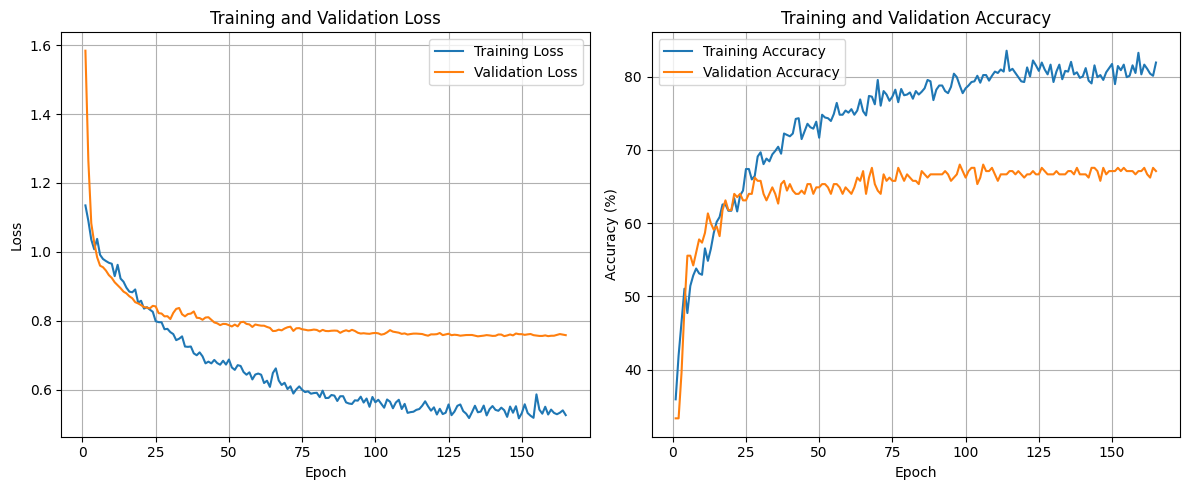

In [37]:
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.decomposition import PCA
from torch.utils.data import Dataset, DataLoader
import numpy as np
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTE

# Set random seed for reproducibility
torch.manual_seed(42)
np.random.seed(42)

# Load datasets
train_df = pd.read_csv('/kaggle/input/predict-u-s-engineering-salaries/train.csv')
test_df = pd.read_csv('/kaggle/input/predict-u-s-engineering-salaries/test.csv')

# Define categorical, numerical, and boolean columns
categorical_cols = ['job_title', 'job_state', 'feature_1', 'job_posted_date']
numerical_cols = ['feature_2'] + [f'job_desc_{i:03d}' for i in range(1, 301)]
boolean_cols = ['feature_3', 'feature_4', 'feature_5', 'feature_6', 'feature_7', 
                'feature_8', 'feature_9', 'feature_11', 'feature_12']

# Handle missing values
# Impute job_state with most frequent value
state_imputer = SimpleImputer(strategy='most_frequent')
train_df['job_state'] = state_imputer.fit_transform(train_df[['job_state']]).flatten()
test_df['job_state'] = state_imputer.transform(test_df[['job_state']]).flatten()

# Impute feature_10 with median
feature10_imputer = SimpleImputer(strategy='median')
train_df['feature_10'] = feature10_imputer.fit_transform(train_df[['feature_10']]).flatten()
test_df['feature_10'] = feature10_imputer.transform(test_df[['feature_10']]).flatten()

# Drop row with missing job_posted_date
train_df = train_df.dropna(subset=['job_posted_date'])

# Feature engineering: Extract year and month from job_posted_date before encoding
def extract_year(date_str):
    try:
        return int(str(date_str)[:4])
    except (ValueError, TypeError):
        return np.nan

def extract_month(date_str):
    try:
        month_str = str(date_str)[5:]
        return int(month_str) if month_str else np.nan
    except (ValueError, TypeError):
        return np.nan

train_df['job_posted_year'] = train_df['job_posted_date'].apply(extract_year)
train_df['job_posted_month'] = train_df['job_posted_date'].apply(extract_month)
test_df['job_posted_year'] = test_df['job_posted_date'].apply(extract_year)
test_df['job_posted_month'] = test_df['job_posted_date'].apply(extract_month)

# Impute any missing year/month values with median
year_imputer = SimpleImputer(strategy='median')
month_imputer = SimpleImputer(strategy='median')
train_df[['job_posted_year', 'job_posted_month']] = year_imputer.fit_transform(train_df[['job_posted_year', 'job_posted_month']])
test_df[['job_posted_year', 'job_posted_month']] = year_imputer.transform(test_df[['job_posted_year', 'job_posted_month']])

# Additional feature engineering
# Interaction feature
train_df['feature_2_times_10'] = train_df['feature_2'] * train_df['feature_10']
test_df['feature_2_times_10'] = test_df['feature_2'] * test_df['feature_10']
numerical_cols.append('feature_2_times_10')

# Polynomial features
train_df['feature_2_squared'] = train_df['feature_2'] ** 2
test_df['feature_2_squared'] = test_df['feature_2'] ** 2
train_df['feature_10_squared'] = train_df['feature_10'] ** 2
test_df['feature_10_squared'] = test_df['feature_10'] ** 2
numerical_cols.extend(['feature_2_squared', 'feature_10_squared'])

# Categorical interaction
train_df['title_state_interaction'] = train_df['job_title'].astype(str) + '_' + train_df['job_state'].astype(str)
test_df['title_state_interaction'] = test_df['job_title'].astype(str) + '_' + test_df['job_state'].astype(str)
categorical_cols.append('title_state_interaction')

# Encode categorical variables
label_encoders = {}
for col in categorical_cols:
    all_values = pd.concat([train_df[col], test_df[col]]).unique()
    le = LabelEncoder()
    le.fit(all_values)
    train_df[col] = le.transform(train_df[col])
    test_df[col] = le.transform(test_df[col])
    label_encoders[col] = le

# Convert boolean columns to integers
for col in boolean_cols:
    train_df[col] = train_df[col].astype(int)
    test_df[col] = test_df[col].astype(int)

# Scale numerical features
scaler = StandardScaler()
train_df[numerical_cols] = scaler.fit_transform(train_df[numerical_cols])
test_df[numerical_cols] = scaler.transform(test_df[numerical_cols])

# Dimensionality reduction with PCA on job_desc_* columns
job_desc_cols = [f'job_desc_{i:03d}' for i in range(1, 301)]
pca = PCA(n_components=150)  # Increased components
train_job_desc_pca = pca.fit_transform(train_df[job_desc_cols])
test_job_desc_pca = pca.transform(test_df[job_desc_cols])

# Create DataFrames for PCA components
train_pca_df = pd.DataFrame(train_job_desc_pca, columns=[f'job_desc_pca_{i+1}' for i in range(150)], index=train_df.index)
test_pca_df = pd.DataFrame(test_job_desc_pca, columns=[f'job_desc_pca_{i+1}' for i in range(150)], index=test_df.index)

# Concatenate PCA components to avoid fragmentation
train_df = pd.concat([train_df.drop(columns=job_desc_cols), train_pca_df], axis=1)
test_df = pd.concat([test_df.drop(columns=job_desc_cols), test_pca_df], axis=1)

# Prepare target variable
target_encoder = LabelEncoder()
train_df['salary_category'] = target_encoder.fit_transform(train_df['salary_category'])

# Prepare features and target
X = train_df.drop(columns=['obs', 'salary_category'])
y = train_df['salary_category']
X_test = test_df.drop(columns=['obs'])

# Apply SMOTE to handle class imbalance
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

# Split data into train, validation, and test sets
X_train, X_temp, y_train, y_temp = train_test_split(X_resampled, y_resampled, test_size=0.3, random_state=42, stratify=y_resampled)
X_val, X_test_internal, y_val, y_test_internal = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)

# Custom Dataset class
class SalaryDataset(Dataset):
    def __init__(self, X, y=None):
        self.X = torch.tensor(X.values, dtype=torch.float32)
        self.y = torch.tensor(y.values, dtype=torch.long) if y is not None else None
    
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        if self.y is not None:
            return self.X[idx], self.y[idx]
        return self.X[idx]

# Create DataLoaders with increased batch size
train_dataset = SalaryDataset(X_train, y_train)
val_dataset = SalaryDataset(X_val, y_val)
test_internal_dataset = SalaryDataset(X_test_internal, y_test_internal)
test_dataset = SalaryDataset(X_test)

train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=128, shuffle=False)
test_internal_loader = DataLoader(test_internal_dataset, batch_size=128, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)

# Define the enhanced neural network with residual connections
class SalaryClassifier(nn.Module):
    def __init__(self, input_size, hidden_size=1024, num_classes=3):
        super(SalaryClassifier, self).__init__()
        self.layer1 = nn.Linear(input_size, hidden_size)
        self.bn1 = nn.BatchNorm1d(hidden_size)
        self.swish1 = nn.SiLU()  # Swish activation
        self.dropout1 = nn.Dropout(0.2)
        
        self.layer2 = nn.Linear(hidden_size, hidden_size // 2)
        self.bn2 = nn.BatchNorm1d(hidden_size // 2)
        self.swish2 = nn.SiLU()
        self.dropout2 = nn.Dropout(0.2)
        
        # Residual connection adapter
        self.residual_adapter1 = nn.Linear(hidden_size, hidden_size // 2)
        
        self.layer3 = nn.Linear(hidden_size // 2, hidden_size // 4)
        self.bn3 = nn.BatchNorm1d(hidden_size // 4)
        self.relu3 = nn.ReLU()
        self.dropout3 = nn.Dropout(0.2)
        
        self.layer4 = nn.Linear(hidden_size // 4, hidden_size // 8)
        self.bn4 = nn.BatchNorm1d(hidden_size // 8)
        self.relu4 = nn.ReLU()
        self.dropout4 = nn.Dropout(0.2)
        
        # Residual connection adapter
        self.residual_adapter2 = nn.Linear(hidden_size // 4, hidden_size // 8)
        
        self.layer5 = nn.Linear(hidden_size // 8, hidden_size // 16)
        self.bn5 = nn.BatchNorm1d(hidden_size // 16)
        self.relu5 = nn.ReLU()
        self.dropout5 = nn.Dropout(0.2)
        
        self.layer6 = nn.Linear(hidden_size // 16, num_classes)
    
    def forward(self, x):
        # Block 1
        x1 = self.layer1(x)
        x1 = self.bn1(x1)
        x1 = self.swish1(x1)
        x1 = self.dropout1(x1)
        
        # Block 2 with residual
        x2 = self.layer2(x1)
        x2 = self.bn2(x2)
        x2 = self.swish2(x2)
        x2 = self.dropout2(x2)
        residual1 = self.residual_adapter1(x1)
        x2 = x2 + residual1
        
        # Block 3
        x3 = self.layer3(x2)
        x3 = self.bn3(x3)
        x3 = self.relu3(x3)
        x3 = self.dropout3(x3)
        
        # Block 4 with residual
        x4 = self.layer4(x3)
        x4 = self.bn4(x4)
        x4 = self.relu4(x4)
        x4 = self.dropout4(x4)
        residual2 = self.residual_adapter2(x3)
        x4 = x4 + residual2
        
        # Block 5
        x5 = self.layer5(x4)
        x5 = self.bn5(x5)
        x5 = self.relu5(x5)
        x5 = self.dropout5(x5)
        
        # Output
        x6 = self.layer6(x5)
        return x6

# Initialize model, loss function, and optimizer
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = SalaryClassifier(input_size=X.shape[1]).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.00003, weight_decay=1e-4)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=7, verbose=True)

# Early stopping parameters
patience = 30
best_val_loss = float('inf')
epochs_no_improve = 0
early_stop = False

# Lists to store losses and accuracies for plotting
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

# Training loop with early stopping
num_epochs = 300
for epoch in range(num_epochs):
    model.train()
    train_loss = 0
    train_correct = 0
    train_total = 0
    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)  # Gradient clipping
        optimizer.step()
        train_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        train_total += y_batch.size(0)
        train_correct += (predicted == y_batch).sum().item()
    
    train_loss /= len(train_loader)
    train_accuracy = 100 * train_correct / train_total
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)
    
    # Validation
    model.eval()
    val_loss = 0
    correct = 0
    total = 0
    with torch.no_grad():
        for X_batch, y_batch in val_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            val_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += y_batch.size(0)
            correct += (predicted == y_batch).sum().item()
    
    val_loss /= len(val_loader)
    val_accuracy = 100 * correct / total
    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)
    
    print(f'Epoch {epoch+1}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Train Acc: {train_accuracy:.2f}%, Val Acc: {val_accuracy:.2f}%')
    
    # Scheduler step
    scheduler.step(val_loss)
    
    # Early stopping check
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        epochs_no_improve = 0
        torch.save(model.state_dict(), 'best_model.pt')
    else:
        epochs_no_improve += 1
        if epochs_no_improve >= patience:
            print('Early stopping triggered')
            early_stop = True
            break

# Plot training and validation metrics
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(range(1, len(train_losses) + 1), train_losses, label='Training Loss')
plt.plot(range(1, len(val_losses) + 1), val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(range(1, len(train_accuracies) + 1), train_accuracies, label='Training Accuracy')
plt.plot(range(1, len(val_accuracies) + 1), val_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.savefig('training_metrics_plot.png')

# Load best model
model.load_state_dict(torch.load('best_model.pt'))

# Evaluate on internal test set
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for X_batch, y_batch in test_internal_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        outputs = model(X_batch)
        _, predicted = torch.max(outputs.data, 1)
        total += y_batch.size(0)
        correct += (predicted == y_batch).sum().item()

print(f'Internal Test Accuracy: {100 * correct / total:.2f}%')

# Predict on test set
model.eval()
predictions = []
with torch.no_grad():
    for X_batch in test_loader:
        X_batch = X_batch.to(device)
        outputs = model(X_batch)
        _, predicted = torch.max(outputs.data, 1)
        predictions.extend(predicted.cpu().numpy())

# Decode predictions
predictions = target_encoder.inverse_transform(predictions)

# Create submission
submission = pd.DataFrame({
    'obs': test_df['obs'],
    'salary_category': predictions
})

# Save submission
submission.to_csv('submission.csv', index=False)

# Display first few predictions
print(submission.head())